In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import calendar

In [6]:
pnc_path = r"C:\Users\willd\OneDrive\Desktop\Budget\statements\pnc_csvs"
chase_path = r"C:\Users\willd\OneDrive\Desktop\Budget\statements\chase_csvs"

In [7]:
# combine multiple pnc statements
def combine(path):
    df_list = []
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        df = pd.read_csv(full_path)
        df_list.append(df)
    combined = pd.concat(df_list)
    combined.columns.values[0] = "Date"
    no_dup = combined.drop_duplicates(subset=['Date', 'Description'], keep='first', inplace=False, ignore_index=True)
    return no_dup

# function to fill ammount column in the pnc dataframe 
def amount_fill(data):
    if '$' in str(data['Withdrawals']):
        amount = '-' + data['Withdrawals']
    else:
        amount = data['Deposits']
    return float(amount.replace('$', '').replace(',', ''))

In [48]:
#compile all files in each folder
pnc_full = combine(pnc_path)
chase_full = combine(chase_path)

#make one row of just amount from withdrawls and eposits
pnc_full['Amount'] = pnc_full.apply(amount_fill, axis=1)

# add catacories to pnc data frame 
df = pnc_full['Description']
df2 = pnc_full['Amount']
cat_condition = [(df.str.contains('VENMO')) & (df2 > 0) & (df2 < 600),(df.str.contains('VENMO'))& (df2 > 0) & (df2 > 600), (df.str.contains('VENMO')) & (df2 < 0), (df.str.contains('SPOTIFY') | df.str.contains('APPLE')),
                 (df.str.contains('ACTALENT')), (df.str.contains('CHECK'))
                , (df.str.contains('SCHWAB BROK'))]
cat_value = ['VENMO IN','KIKI RENT','VENMO OUT', 'SUBSCRIP', 'Belair', 'RENT', 'SCHWAB']
pnc_full['Category'] = np.select(cat_condition, cat_value)
# make a misc catagory of remaining  
pnc_full.loc[pnc_full['Category'] == '0', 'Category'] = 'Misc'

In [90]:
# reduce both data frames to relevant columns
chase_reduced = chase_full[["Date", 'Description', "Category", "Amount"]]
pnc_reduced = pnc_full[["Date", 'Description', "Category", "Amount"]]

# remove CC Payments from both 
pnc_no_cc = pnc_reduced[~pnc_reduced['Description'].str.contains('CHASE CREDIT CRD EPA')]
# remove pnc transfers 
pnc_no_transfer = pnc_no_cc[~pnc_no_cc['Description'].str.contains('ONLINE TRANSFER')]
chase_no_cc = chase_reduced[chase_reduced['Amount'] < 0]

# combine pnc and chase for analysis 
both = [chase_no_cc, pnc_no_transfer]
full_df = pd.concat(both)

# change date dtype
full_df['Date'] = pd.to_datetime(full_df['Date'])

#reduce data set to only include same months 
full_df = full_df[full_df['Date'] >= '2023-09-01']

# add month column 
full_df['Month'] = pd.DatetimeIndex(full_df['Date']).month
# change month colum to date
full_df['Month'] = full_df['Month'].apply(lambda x: calendar.month_abbr[x])

In [4]:
# remove venmo in > $500 from rent by mont 
# month_list = full_df['Month'].unique()
# l = ['KIKI RENT', 'RENT']  
# regstr = '&'.join(l)
# for mon in month_list:
#     month_df = full_df[full_df['Month'] == mon]
    
#     if month_df['Category'].str.contains(regstr):
#         print(1)
        
        
#     deduct = month_df.loc['VENMO IN', 'Amount']
#     deduct = month_df.loc[(month_df['Category'] == 'VENMO IN')&(month_df['Amount'] > 600), 'Amount']
#     deduct = month_df['Amount'].loc[(month_df['Category'] == 'VENMO IN')&(month_df['Amount'] > 500)].values
#     if len(deduct) > 0:
#         rent = 
#         amount = rent - deduct[0]
#         pnc_full.loc[pnc_full['Category'] == '0', 'Category'] = 'Misc'
#     print(full_df[full_df['Category'] == 'RENT'])
#     print(deduct)


In [52]:
money_in = full_df[full_df['Amount'] > 0]
money_out = full_df[full_df['Amount'] < 0]

In [53]:
money_out.loc[money_out['Amount'] < 0, 'Amount'] = 0 - money_out['Amount']

C:\Users\willd\AppData\Local\Temp\ipykernel_11800\1903825643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_out.loc[money_out['Amount'] < 0, 'Amount'] = 0 - money_out['Amount']


In [13]:
# money_out['Amount'] = 0 - money_out['Amount']

In [54]:
money_out.head(5)

,Date,Description,Category,Amount,Month
0,2023-12-02,TST* WINDY SADDLE CAFE,Food & Drink,54.29,Dec
1,2023-12-01,PARKMOBILE,Travel,2.45,Dec
2,2023-11-29,PROGRESSIVE INS,Bills & Utilities,594.00,Nov
3,2023-11-27,KING SOOPERS #0682 FUE,Gas,47.75,Nov
5,2023-11-26,ZENNI OPTICAL INC.,Health & Wellness,4.95,Nov


In [55]:
month_list = full_df['Month'].unique()
dict_list = []
for mon in month_list:
    df_in = money_in[money_in['Month'] == mon]
    df_out = money_out[money_out['Month'] == mon]
    month_in = df_in['Amount'].sum()
    month_out = df_out['Amount'].sum()
    dict1 = {'Month': mon, 'Money In': month_in, 'Money Out': month_out}
    dict_list.append(dict1)
monthly_ratio = pd.DataFrame(dict_list)

In [56]:
monthly_ratio

,Month,Money In,Money Out
0,Dec,0.00,56.74
1,Nov,6634.92,3512.73
2,Oct,5650.98,6299.18
3,Sep,5699.02,3360.89


In [105]:


# Visualization functions
# Pie Chart
def monthly_pie(cat_tot, month):
    total_out = round(cat_tot['Amount'].sum(), 2)
    labels = cat_tot.index.tolist()
    sizes = cat_tot['Amount']
    pie = plt.pie(sizes,autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f"{month} Expenses by Category ${total_out}")
    labels = [f'{l}, {round(s/total_out*100),2}%' for l, s in zip(labels, sizes)]
    plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
    plt.show()

#bar chart
def bar_chart(cat_tot, month):
    total_out = round(cat_tot['Amount'].sum(), 2)
    x = cat_tot.index.tolist()
    y = cat_tot['Amount']
    fig, ax = plt.subplots(figsize =(16, 9))
    # Horizontal Bar Plot
    ax.barh(x, y)
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    # Show top values 
    ax.invert_yaxis()
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
    # Add Plot Title
    ax.set_title(f"{month} Expenses by Category ${total_out} ",
                 loc ='left', )

    # Add Text watermark
    fig.text(0.9, 0.15, 'wcd', fontsize = 12,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)


In [ ]:
# df 

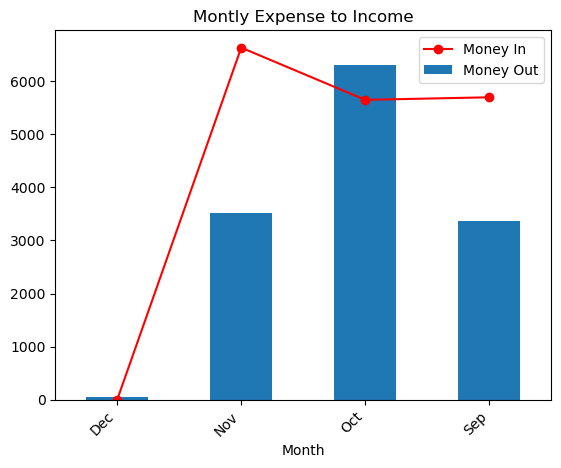

In [58]:
# Montly Expense to Income
ax = monthly_ratio.plot(
    x='Month', y = 'Money In', linestyle='-', color="r", marker='o',use_index=False)
monthly_ratio.plot(x='Month', y = 'Money Out', kind='bar',
                                                        ax=ax)
plt.title("Montly Expense to Income")
plt.xticks(rotation=45, ha='right')
plt.show()

In [82]:
full_df[full_df['Month'] == 'Nov']

,Date,Description,Category,Amount,Month
2,2023-11-29,PROGRESSIVE INS,Bills & Utilities,-594.00,Nov
3,2023-11-27,KING SOOPERS #0682 FUE,Gas,-47.75,Nov
5,2023-11-26,ZENNI OPTICAL INC.,Health & Wellness,-4.95,Nov
6,2023-11-26,XCEL EZ-PAY WEB,Bills & Utilities,-70.70,Nov
7,2023-11-24,GOLDEN PINON LLC,Food & Drink,-44.69,Nov
8,2023-11-22,CIRCLE K # 44062,Groceries,-7.35,Nov
9,2023-11-23,SPEEDWAY 09120 1318 PA,Gas,-8.97,Nov
10,2023-11-23,VZWRLSS*APOCC VISN,Bills & Utilities,-88.55,Nov
11,2023-11-21,WALGREENS #10117,Health & Wellness,-8.59,Nov
13,2023-11-18,SQ *DOWNHILL DUKE'S,Food & Drink,-24.09,Nov


In [89]:
month_list = full_df['Month'].unique()
for mon in month_list:
    month_df = full_df[full_df['Month'] == mon]
    y = ['KIKI RENT', 'RENT']
    month_df = month_df[month_df.Category.str.contains(' | '.join(y))]
    print(len(month_df))
#     measure = full_df[full_df['Category'].str.contains(y)]
#     month_df['re'] = month_df['Category'].apply(lambda x: ('') if  y in x & z)


0
1
1
1


In [86]:
month_df[month_df.Category.str.contains(' | '.join(y))]

,Date,Description,Category,Amount,Month
46,2023-09-27,ACH CREDIT XXXXX5291 VENMO CAS...,KIKI RENT,909.11,Sep


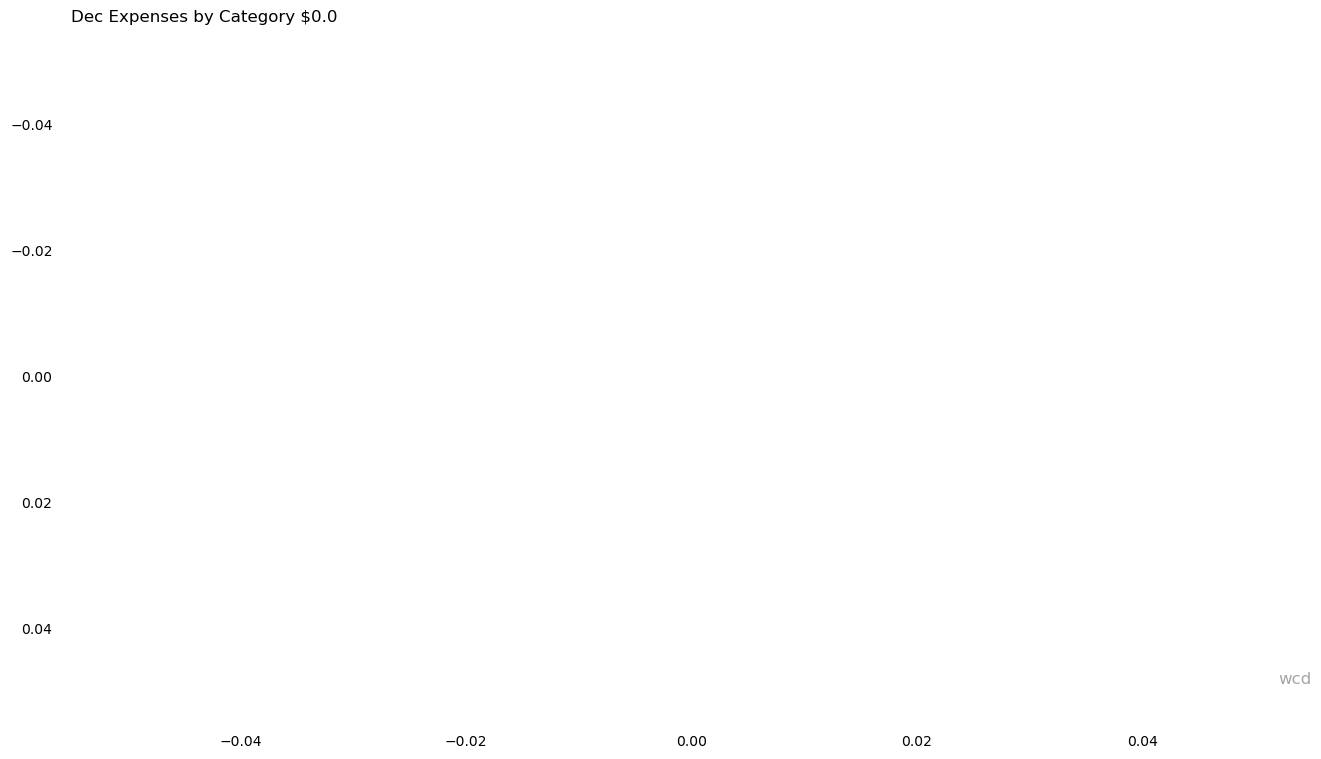

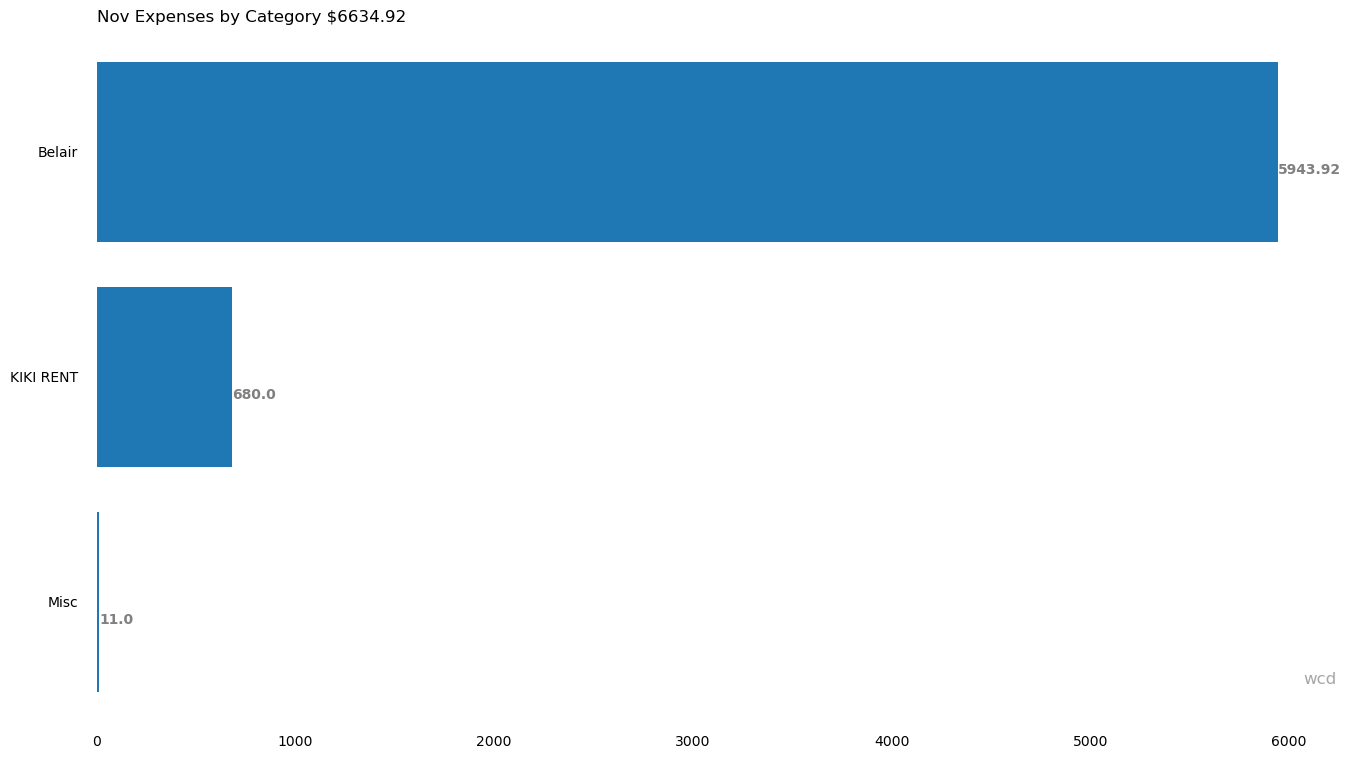

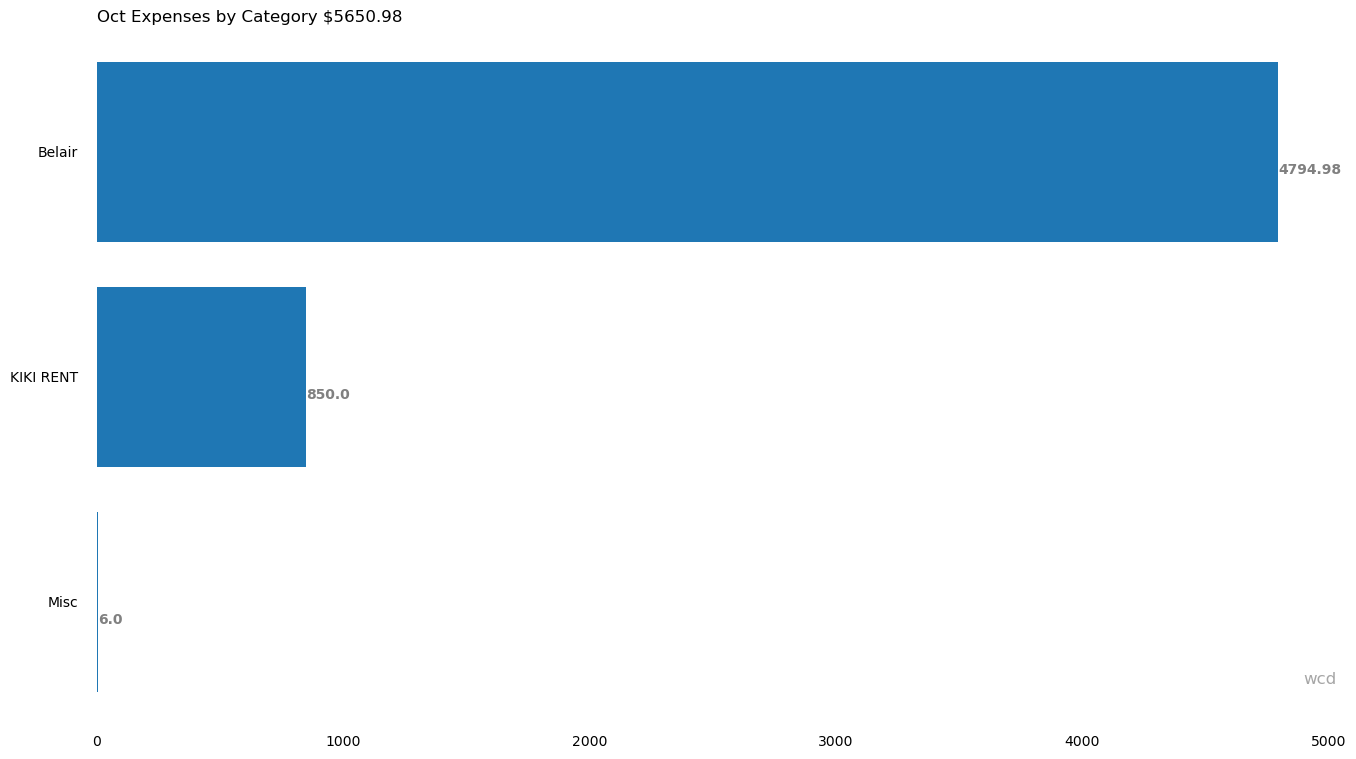

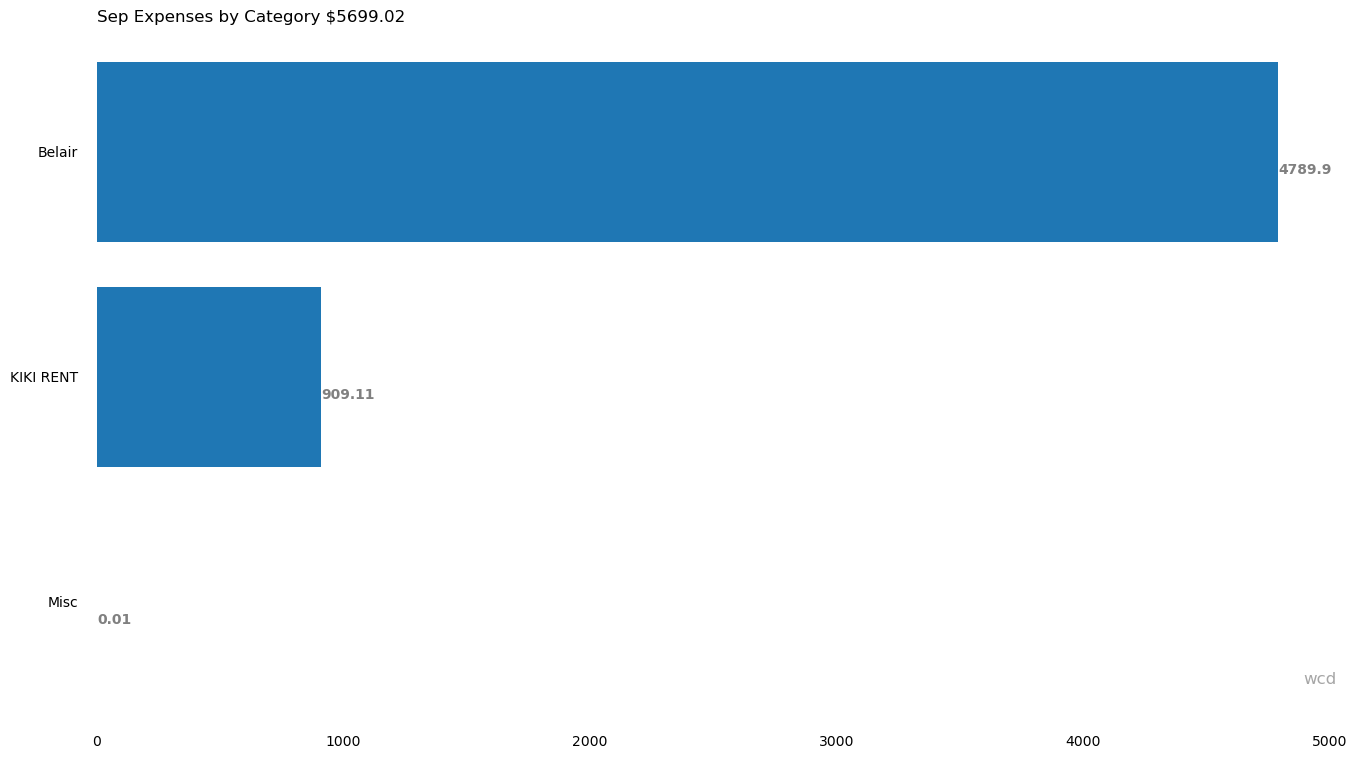

In [107]:
month_list = full_df['Month'].unique()
for mon in month_list:
#     month_df = money_out[money_out['Month'] == mon]
    month_df = money_in[money_in['Month'] == mon]
    cat_tot = month_df.groupby('Category').sum()
#     monthly_pie(cat_tot, str(mon))
    bar_chart(cat_tot, mon)

In [47]:
money_out[money_out['Month'] == 'Nov'].sort_values(by='Category')

,Date,Description,Category,Amount,Month
2,2023-11-29,PROGRESSIVE INS,Bills & Utilities,594.00,Nov
6,2023-11-26,XCEL EZ-PAY WEB,Bills & Utilities,70.70,Nov
10,2023-11-23,VZWRLSS*APOCC VISN,Bills & Utilities,88.55,Nov
7,2023-11-24,GOLDEN PINON LLC,Food & Drink,44.69,Nov
21,2023-11-07,MCDONALD'S F6010,Food & Drink,12.44,Nov
13,2023-11-18,SQ *DOWNHILL DUKE'S,Food & Drink,24.09,Nov
18,2023-11-10,BARRELS &amp; BOTTLES,Food & Drink,71.56,Nov
17,2023-11-13,SONIC DRIVE IN #4415,Food & Drink,15.19,Nov
3,2023-11-27,KING SOOPERS #0682 FUE,Gas,47.75,Nov
27,2023-11-02,CIRCLE K # 41165,Gas,6.87,Nov


In [64]:
money_in[money_in['Month'] == 'Nov'].sort_values(by='Category')

,Date,Description,Category,Amount,Month
0,2023-11-29,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,Nov
9,2023-11-21,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.77,Nov
13,2023-11-15,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,Nov
17,2023-11-08,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.78,Nov
21,2023-11-01,"ACH CREDIT 07987436 ACTALENT, INC. DIR DEP",Belair,1188.79,Nov
7,2023-11-22,ACH CREDIT XXXXX9684 VENMO CAS...,KIKI RENT,680.00,Nov
4,2023-11-24,NON-PNC ATM SURCHARGE REIMBURSEMENT,Misc,5.00,Nov
5,2023-11-24,ATM TRANSACTION FEE REIMBURSEMENT,Misc,6.00,Nov


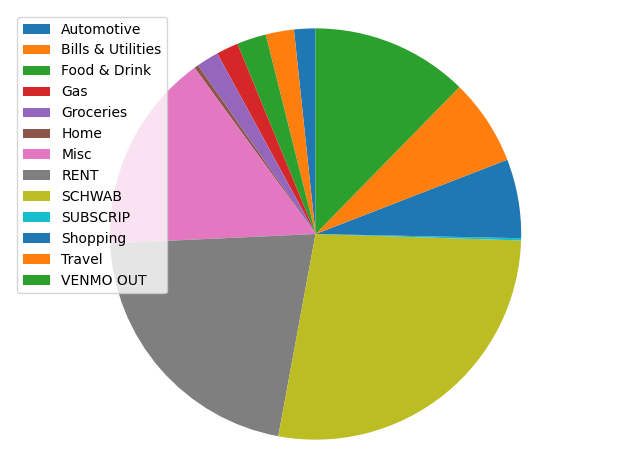

In [32]:
labels = cat_tot.index.tolist()
amounts = cat_tot['Amount']

patches, texts = plt.pie(amounts, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

Text(0.9, 0.15, 'wcd')

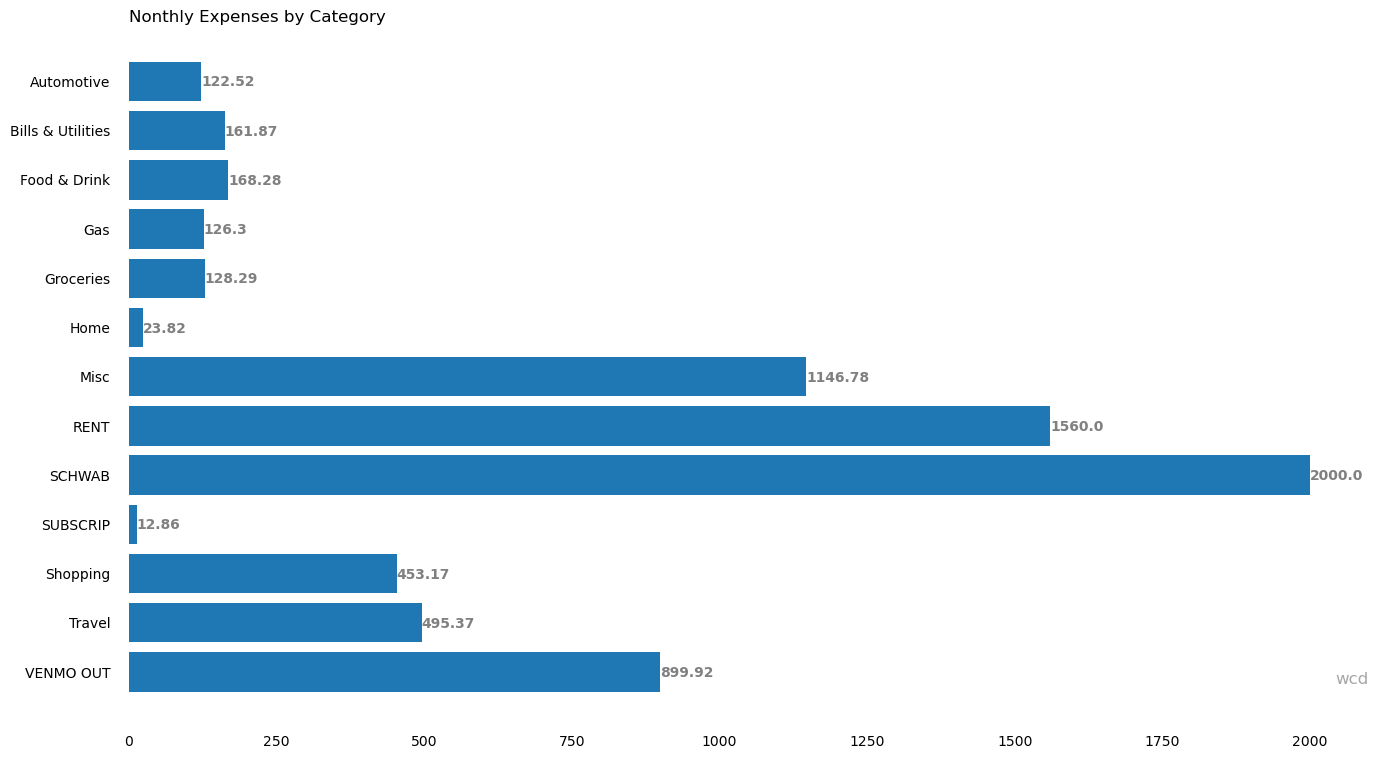

In [120]:
x = cat_tot.index.tolist()
y = cat_tot['Amount']

fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(x, y)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
# Show top values 
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
# Add Plot Title
ax.set_title('Nonthly Expenses by Category',
             loc ='left', )

# Add Text watermark
fig.text(0.9, 0.15, 'wcd', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)

# Show Plot
# plt.show()

In [42]:
def bar_chart(cat_tot):
    x = cat_tot.index.tolist()
    y = cat_tot['Amount']
    fig, ax = plt.subplots(figsize =(16, 9))
    # Horizontal Bar Plot
    ax.barh(x, y)
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    # Show top values 
    ax.invert_yaxis()
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
    # Add Plot Title
    ax.set_title('Nonthly Expenses by Category',
                 loc ='left', )

    # Add Text watermark
    fig.text(0.9, 0.15, 'wcd', fontsize = 12,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)

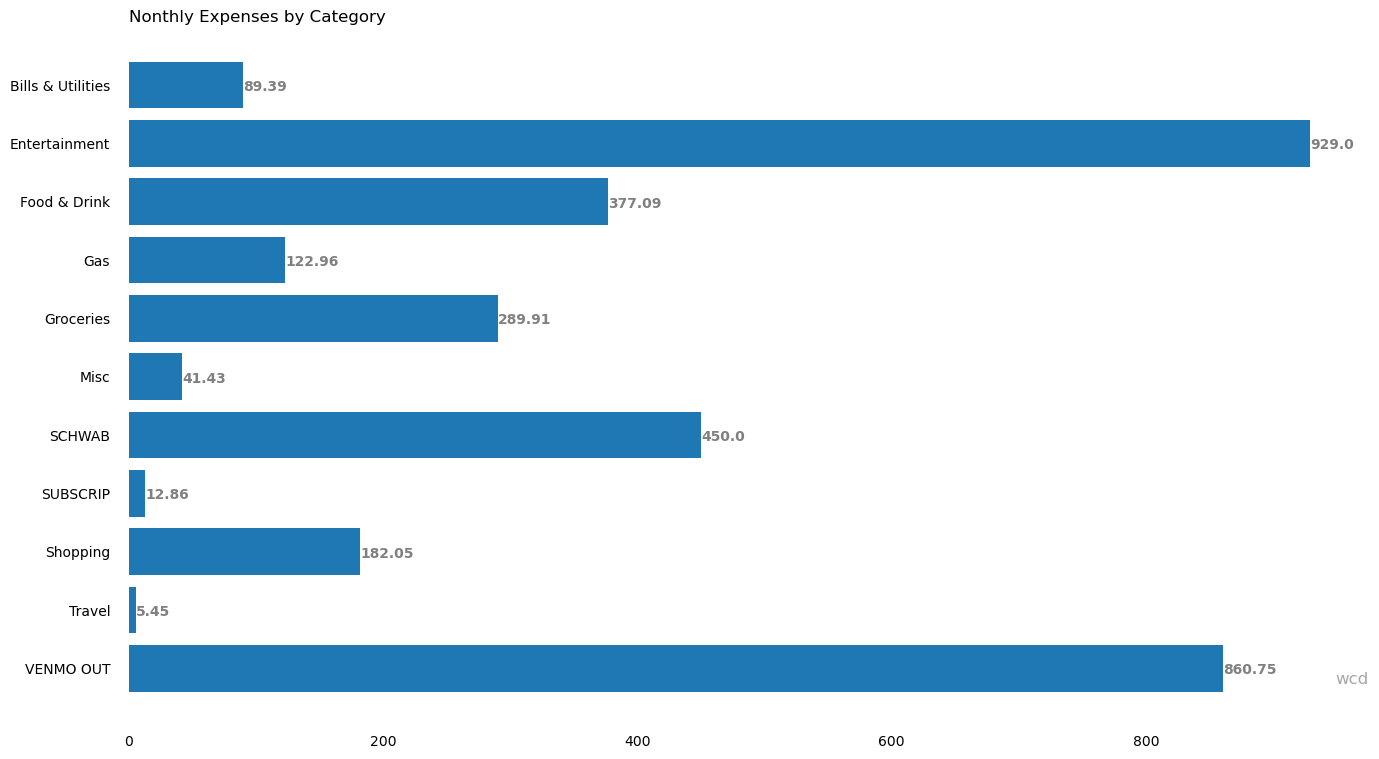

None


In [17]:
expense_pivot = money_out.pivot_table(values='Amount', index='Month', columns='Category', aggfunc='sum')

In [100]:
expense_pivot

Category,Automotive,Bills & Utilities,Entertainment,Food & Drink,Gas,Groceries,Health & Wellness,Home,Misc,RENT,SCHWAB,SUBSCRIP,Shopping,Travel,VENMO OUT
Month,,,,,,,,,,,,,,,
9,NaN,89.39,929.0,601.67,122.96,289.91,NaN,NaN,41.43,NaN,450.0,12.86,182.05,5.45,860.75
10,122.52,161.87,NaN,168.28,127.90,128.29,NaN,23.82,146.78,1560.0,2000.0,12.86,457.45,523.85,899.92
11,NaN,NaN,NaN,99.19,62.07,9.87,179.7,NaN,NaN,1680.0,NaN,NaN,25.78,NaN,320.82


In [107]:
month_exp = money_out.groupby('Month').sum()
month_inc = money_in.groupby('Month').sum()

In [108]:
print(month_exp)
print(month_inc)

        Amount
Month         
9      3585.47
10     6333.54
11     2377.43
        Amount
Month         
9      5699.02
10     5650.98
11     3566.36


In [110]:
x = month_exp[0]
y1 = month_exp['Amount']
y2 = month_inc['Amount']
plt.plot(x, y1)

KeyError: 0

In [73]:
ytd = money_in.loc[money_in['Category'] == 'Belair', 'Amount'].sum()
othermoney = money_in.loc[money_in['Category'] != 'Belair', 'Amount'].sum()
as_of = money_in['Date'].max()
expense = money_out['Amount'].sum() - othermoney
income_report = f"""
As of {as_of}, you have made a total of ${ytd}
And you have spent ${expense}"""
print(income_report)


As of 2023-11-15 00:00:00, you have made a total of $13151.24
And you have spent $10531.319999999998
